In [1]:
# library to handle flow matching
!pip install flow-matching 

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import pytorch_lightning as pl
from torch import nn
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X = train.values[:, 1:]
y = train.values[:, 0]
X = X.reshape(X.shape[0], 1, 28, 28)
X.shape

(42000, 1, 28, 28)

In [7]:
X_test = test.values
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

In [113]:
from flow_matching.path import CondOTProbPath
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.embedding_l = nn.Linear(3, dim)

    def forward(self, time):
        device = time.device
        time = torch.cat([time, torch.cos(time), torch.sin(time)], dim=-1)
        return self.embedding_l(time)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.SiLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, c=64):
        super().__init__()
        
        # Time embeddings for each skip connection
        self.time_mlp1 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, c),
            nn.SiLU(),
            nn.Linear(c, c)
        )
        
        self.time_mlp2 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 2*c),
            nn.SiLU(),
            nn.Linear(2*c, 2*c)
        )
        
        self.time_mlp3 = nn.Sequential(
            SinusoidalPositionEmbeddings(c),
            nn.Linear(c, 4*c),
            nn.SiLU(),
            nn.Linear(4*c, 4*c)
        )
        
        # Encoder
        self.conv1 = DoubleConv(in_channels, c)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(c, 2*c)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(2*c, 4*c)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(4*c, 8*c)

        # Decoder
        self.upconv3 = nn.ConvTranspose2d(8*c, 4*c, kernel_size=2, stride=2)
        self.conv5 = DoubleConv(12*c, 4*c)  # 4c + 4c + 4c (skip + up + time)
        self.upconv2 = nn.ConvTranspose2d(4*c, 2*c, kernel_size=2, stride=2)
        self.conv6 = DoubleConv(6*c, 2*c)   # 2c + 2c + 2c
        self.upconv1 = nn.ConvTranspose2d(2*c, c, kernel_size=2, stride=2)
        self.conv7 = DoubleConv(3*c, c)     # c + c + c
        
        self.final_conv = nn.Conv2d(c, out_channels, kernel_size=1)

    
    def forward(self, x, t):
        # Time embeddings
        t = t.view(-1, 1)
        if t.numel() == 1:
            t = t.expand(x.shape[0], -1)
        t1 = self.time_mlp1(t)        # Shape: [batch, c]
        t2 = self.time_mlp2(t)        # Shape: [batch, 2c]
        t3 = self.time_mlp3(t)        # Shape: [batch, 4c]
        
        # Encoder
        conv1 = self.conv1(x)                 # Shape: [batch, c, H, W]
        pool1 = self.pool1(conv1)             # Shape: [batch, c, H/2, W/2]
        
        conv2 = self.conv2(pool1)             # Shape: [batch, 2c, H/2, W/2]
        pool2 = self.pool2(conv2)             # Shape: [batch, 2c, H/4, W/4]
        
        conv3 = self.conv3(pool2)             # Shape: [batch, 4c, H/4, W/4]
        pool3 = self.pool3(conv3)             # Shape: [batch, 4c, H/8, W/8]
        
        conv4 = self.conv4(pool3)             # Shape: [batch, 8c, H/8, W/8]
        
        # Helper function for padding
        def pad_if_needed(upsampled, skip):
            if (upsampled.shape[-1] + 1) == skip.shape[-1]:
                return F.pad(upsampled, (0, 1, 0, 1), mode='replicate')
            return upsampled
        # Decoder Step 1
        up3 = self.upconv3(conv4)              # Shape: [batch, 4c, H/4, W/4]
        up3 = pad_if_needed(up3, conv3)        # Ensure up3 matches conv3 dimensions
        # Reshape t3 to [batch, 4c, H/4, W/4]
        t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up3.size(2), up3.size(3))  
        # Alternatively, use expand to save memory:
        # t_emb3 = t3.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, up3.size(2), up3.size(3))
        concat3 = torch.cat([up3, conv3, t_emb3], dim=1)   # Shape: [batch, 12c, H/4, W/4]
        conv5 = self.conv5(concat3)            # Shape: [batch, 4c, H/4, W/4]

        # Decoder Step 2
        up2 = self.upconv2(conv5)              # Shape: [batch, 2c, H/2, W/2]
        up2 = pad_if_needed(up2, conv2)        # Ensure up2 matches conv2 dimensions
        # Reshape t2 to [batch, 2c, H/2, W/2]
        t_emb2 = t2.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up2.size(2), up2.size(3))
        concat2 = torch.cat([up2, conv2, t_emb2], dim=1)   # Shape: [batch, 6c, H/2, W/2]
        conv6 = self.conv6(concat2)            # Shape: [batch, 2c, H/2, W/2]

        # Decoder Step 3
        up1 = self.upconv1(conv6)              # Shape: [batch, c, H, W]
        up1 = pad_if_needed(up1, conv1)        # Ensure up1 matches conv1 dimensions
        # Reshape t1 to [batch, c, H, W]
        t_emb1 = t1.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, up1.size(2), up1.size(3))
        concat1 = torch.cat([up1, conv1, t_emb1], dim=1)   # Shape: [batch, 3c, H, W]
        conv7 = self.conv7(concat1)            # Shape: [batch, c, H, W]

        # Final Convolution
        return self.final_conv(conv7)          # Shape: [batch, out_channels, H, W]

In [114]:
import argparse
from typing import Optional, Tuple

import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import pytorch_lightning as pl

# Import flow_matching library components
# Adjust the import paths based on the actual library structure
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
# If the library has different components, adjust accordingly


import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional

class ImageFlowMatcher(pl.LightningModule):
    """
    Flow Matching model for MNIST image generation.
    Utilizes the flow_matching library for path sampling and loss computation.
    """

    def __init__(
        self,
        lr: float = 1e-4,
        num_train_timesteps: int = 1000,
        sigma: float = 0.1,
        step_size: float = 0.05,
        num_steps: int = 1000,
        use_cuda: bool = True
    ):
        super(ImageFlowMatcher, self).__init__()
        self.save_hyperparameters()  # Saves hyperparameters for easy access later

        self.lr = lr
        self.num_train_timesteps = num_train_timesteps
        self.sigma = sigma
        self.step_size = step_size
        self.num_steps = num_steps
        self.normalize_data = True  # Assumes normalization in training_step

        # Initialize the CNN model as the velocity field
        self.model = UNet(1, 1, c=32)

        # Initialize the probability path for flow matching
        self.prob_path = CondOTProbPath()

        self.criterion = nn.MSELoss()
        
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the CNN model.

        Args:
            xt (torch.Tensor): Current state tensor.
            t (torch.Tensor): Time scalar.

        Returns:
            torch.Tensor: Velocity field tensor.
        """
        return self.model(x, t)

    def generate(
        self,
        batch_size: int = 32,
        sample_image_size: Tuple[int, int, int] = (1, 28, 28),
        step_size: float = 0.05,
        num_steps: Optional[int] = None
    ) -> torch.Tensor:
        """
        Generate images using the trained flow model via ODE integration.

        Args:
            batch_size (int): Number of images to generate.
            sample_image_size (Tuple[int, int, int]): Size of each sample image (C, H, W).
            step_size (float): Integration step size.
            num_steps (Optional[int]): Number of integration steps. Defaults to 2.

        Returns:
            torch.Tensor: Generated images tensor.
        """
        if num_steps is None:
            num_steps = 2
        solver = ODESolver(velocity_model=self.model)
        # Initialize from Gaussian noise
        x_init = torch.randn(batch_size, *sample_image_size, device=self.device)

        # Define a uniform time grid
        time_grid = torch.linspace(0, 1, steps=num_steps, device=self.device)

        # Perform ODE integration using the solver
        generated = solver.sample(time_grid=time_grid, x_init=x_init, method='dopri5', step_size=step_size, atol=1e-4, rtol=1e-4)

        # Denormalize if needed
        if self.normalize_data:
            generated = (generated + 1) / 2  # transpose from [-1, 1] to [0, 1]
            generated = torch.clamp(generated, 0.0, 1.0)

        return generated

    def training_step(self, batch, batch_idx):
        """
        Training step for flow matching.

        Args:
            batch (tuple): A batch of data containing images and labels.
            batch_idx (int): Index of the batch.

        Returns:
            torch.Tensor: Training loss.
        """
        images = batch[0]  # MNIST returns (images, labels)

        # Normalize images to [-1, 1]
        if self.normalize_data:
            images = images.float() / 255.
            images = images * 2 - 1  # Normalize [0,1] to [-1,1]

        # Sample initial noise x0
        x0 = torch.randn_like(images)

        # Sample a random t in [0,1] for each sample in the batch
        t = torch.rand(images.size(0), device=self.device)

        # Sample paths for flow matching
        path_batch = self.prob_path.sample(x0, images, t)

        # Predict velocity field at x_t

        # Predict velocity field at x_t
        vt = self.forward(path_batch.x_t, path_batch.t)  # Unconditional generation

        # Compute flow matching loss: MSE between predicted velocity and true velocity
        loss = self.criterion(vt, path_batch.dx_t)
        
        # Log training loss
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step for flow matching.

        Args:
            batch (tuple): A batch of data containing images and labels.
            batch_idx (int): Index of the batch.
        """
        images  = batch[0]

        # Normalize images to [-1, 1]
        if self.normalize_data:
            images = images.float() / 255.
            images = images * 2 - 1 # Normalize [0,1] to [-1,1]

        # Sample initial noise x0
        x0 = torch.randn_like(images)

        # Sample a random t in [0,1] for each sample in the batch
        t = torch.rand(images.size(0), device=self.device)

        # Sample paths for flow matching
        path_batch = self.prob_path.sample(x0, images, t)

        # Predict velocity field at x_t
        vt = self.forward(path_batch.x_t, path_batch.t)

        # Compute flow matching loss
        loss = self.criterion(vt, path_batch.dx_t)
        
        # Log validation loss
        self.log('val_loss', loss, prog_bar=True, logger=True)

        # Optionally, generate and log sample images
        if batch_idx == 0:
            sample_images = self.generate(batch_size=16)
            grid = torchvision.utils.make_grid(sample_images, nrow=4, normalize=False, value_range=(0,1))
            self.logger.experiment.add_image('generated_images', grid, self.current_epoch)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.show()
            plt.close()

    def configure_optimizers(self):
        """
        Configure the optimizer for training.

        Returns:
            torch.optim.Optimizer: Configured optimizer.
        """
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        return optimizer

    @staticmethod
    def add_model_specific_args(parser):
        """
        Add model-specific command-line arguments.

        Args:
            parser (argparse.ArgumentParser): Argument parser.

        Returns:
            argparse.ArgumentParser: Updated parser with model-specific arguments.
        """
        group_parser = parser.add_argument_group(title='FlowMatcher')
        group_parser.add_argument('--lr', type=float, default=1e-4, help='Learning rate')
        group_parser.add_argument('--num_train_timesteps', type=int, default=1000, help='Number of ODE time steps')
        group_parser.add_argument('--sigma', type=float, default=0.1, help='Sigma for the Flow Matcher')
        group_parser.add_argument('--step_size', type=float, default=0.05, help='ODE integration step size')
        group_parser.add_argument('--num_steps', type=int, default=1000, help='Number of ODE integration steps')
        return parser

In [115]:
model = ImageFlowMatcher()

In [116]:
if torch.cuda.is_available():
    trainer = pl.Trainer(max_epochs=100, accelerator='gpu', devices=-1, strategy='ddp_notebook')
else:
    trainer = pl.Trainer(max_epochs=100)

In [117]:
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X))
train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test))
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.05}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


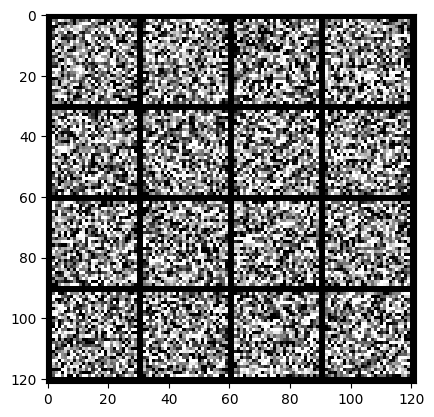

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


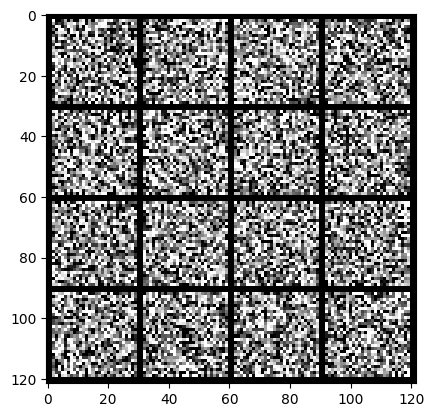

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

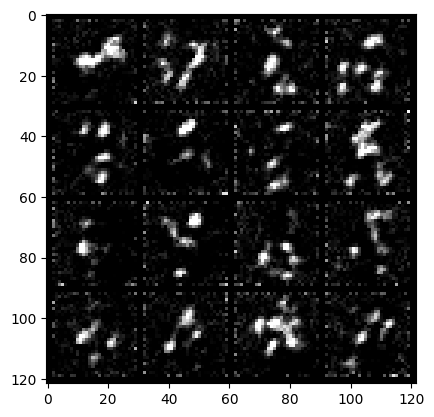

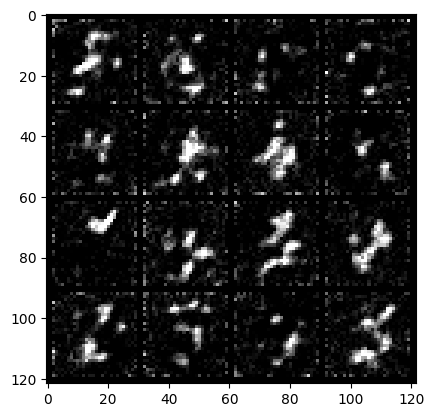

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:431: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Validation: |          | 0/? [00:00<?, ?it/s]

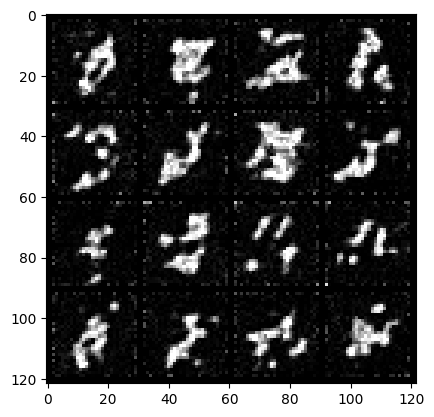

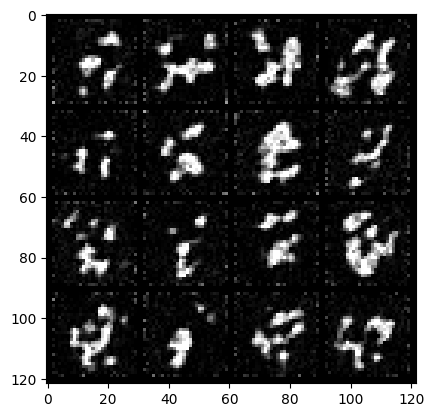

Validation: |          | 0/? [00:00<?, ?it/s]

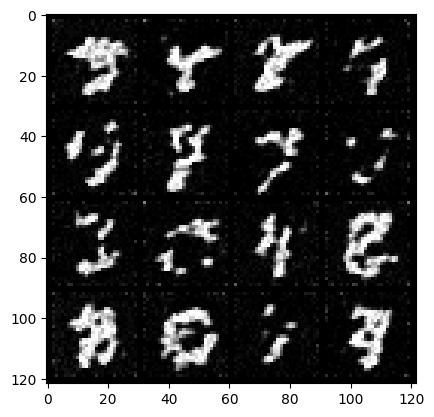

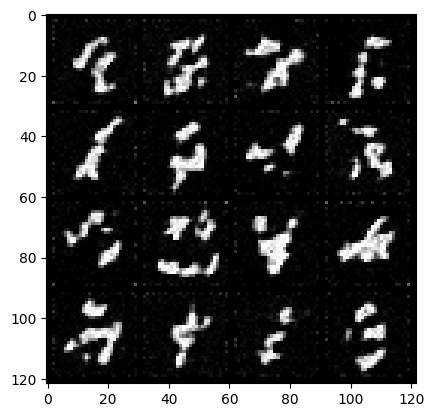

Validation: |          | 0/? [00:00<?, ?it/s]

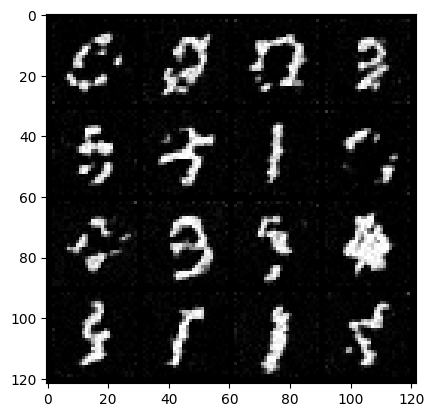

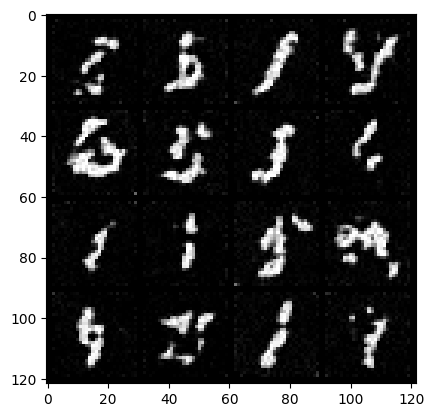

Validation: |          | 0/? [00:00<?, ?it/s]

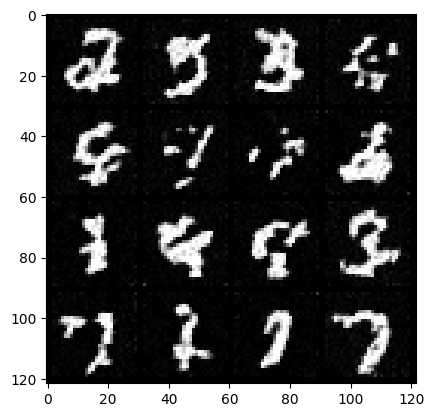

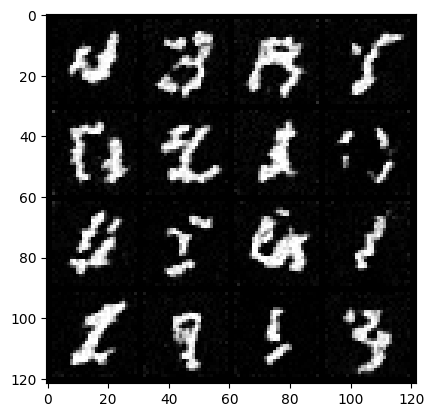

Validation: |          | 0/? [00:00<?, ?it/s]

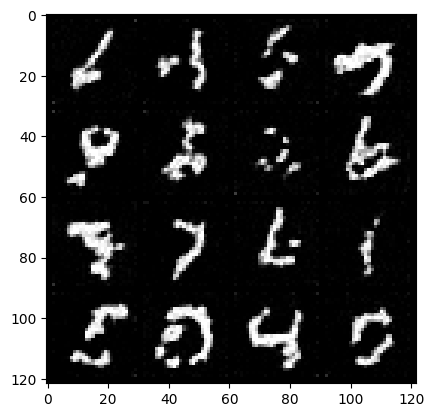

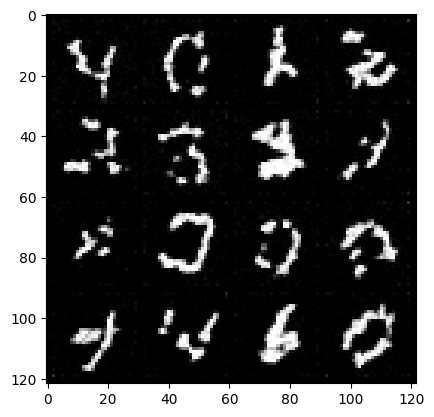

Validation: |          | 0/? [00:00<?, ?it/s]

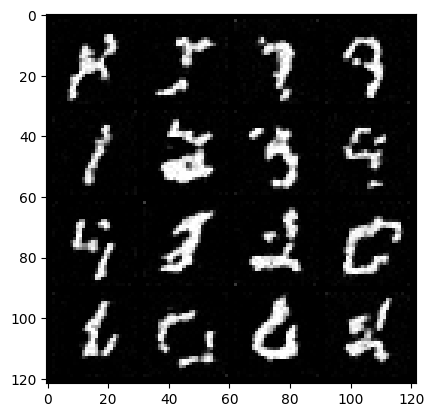

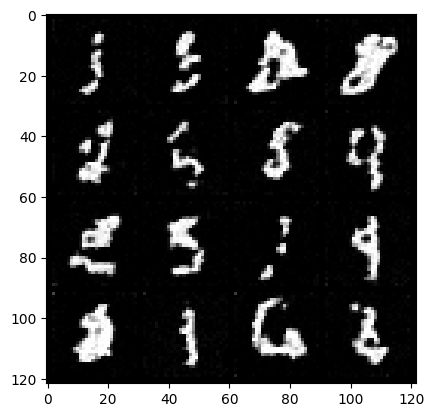

Validation: |          | 0/? [00:00<?, ?it/s]

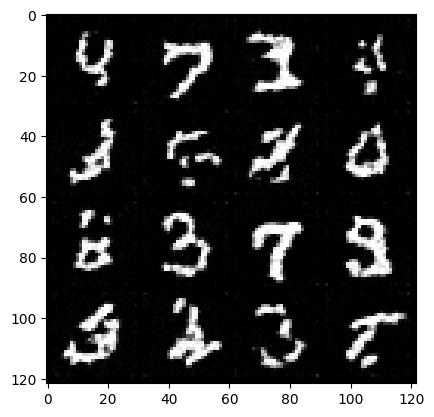

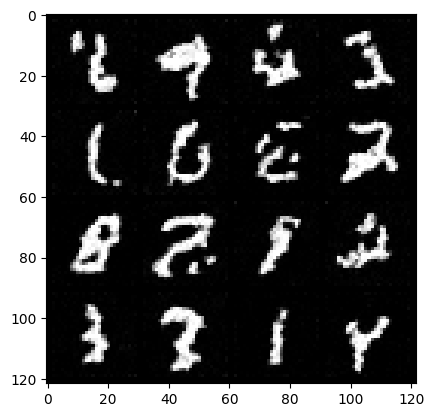

Validation: |          | 0/? [00:00<?, ?it/s]

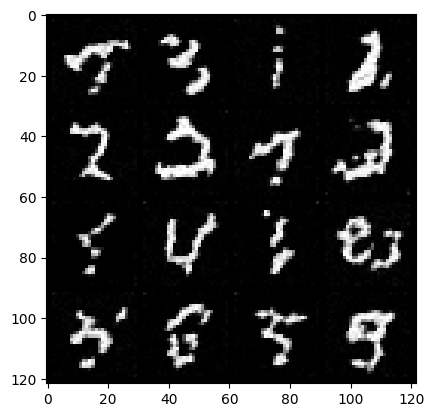

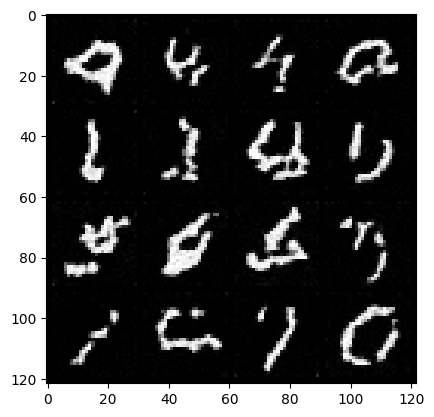

Validation: |          | 0/? [00:00<?, ?it/s]

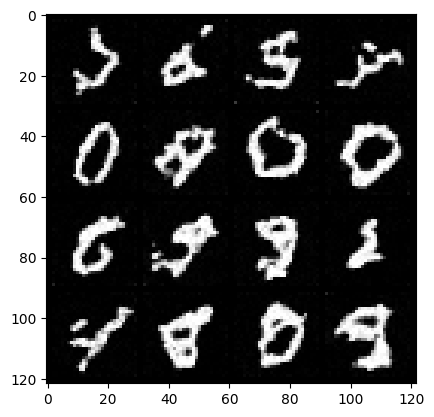

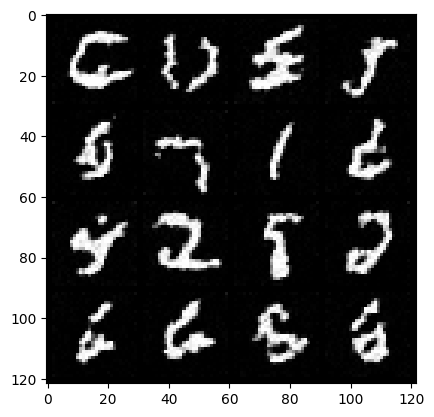

Validation: |          | 0/? [00:00<?, ?it/s]

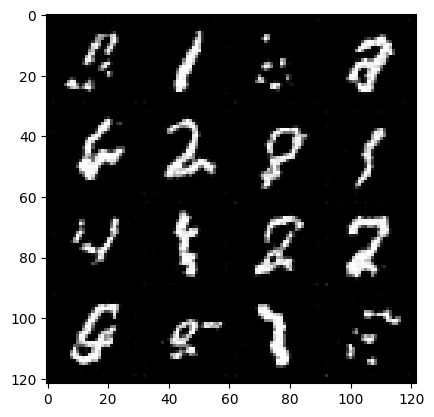

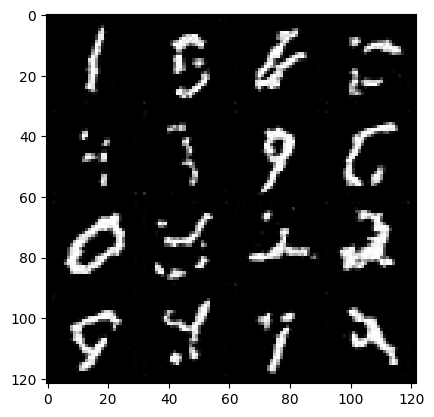

Validation: |          | 0/? [00:00<?, ?it/s]

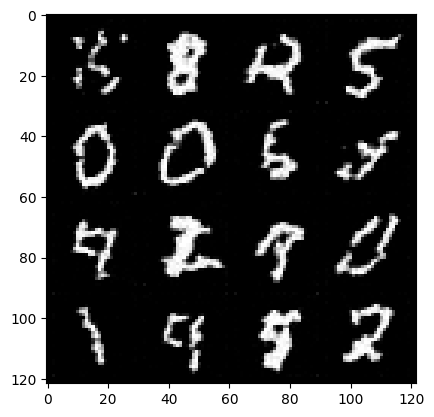

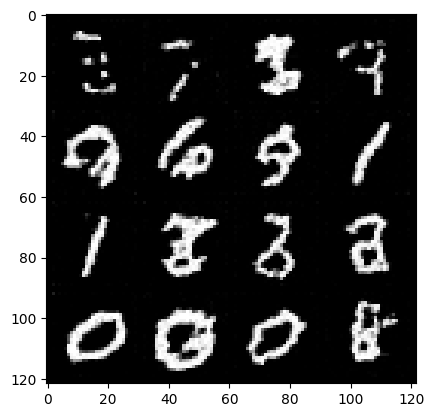

Validation: |          | 0/? [00:00<?, ?it/s]

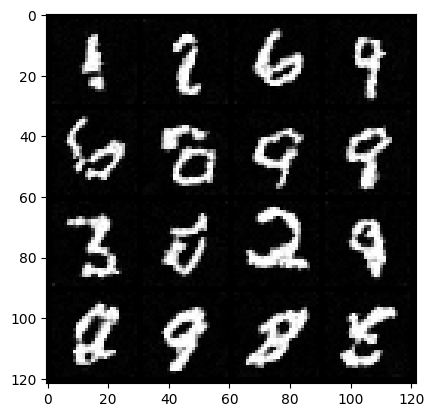

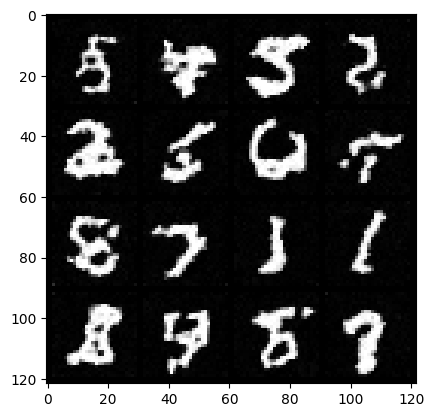

Validation: |          | 0/? [00:00<?, ?it/s]

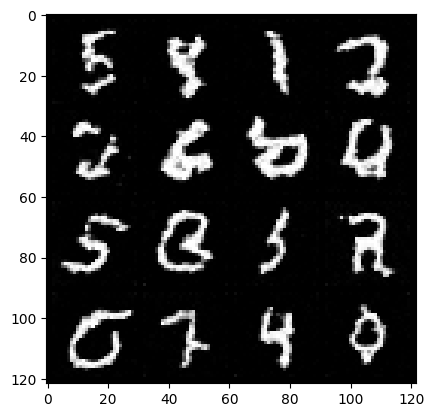

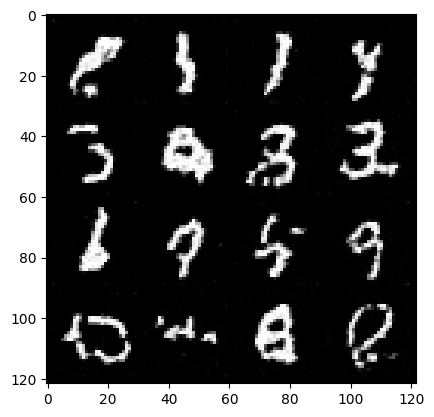

Validation: |          | 0/? [00:00<?, ?it/s]

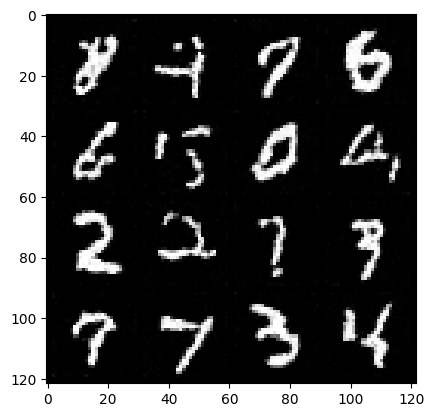

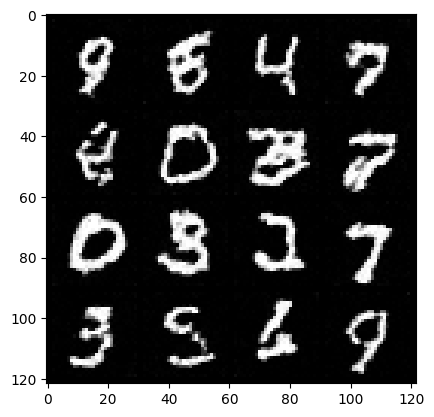

Validation: |          | 0/? [00:00<?, ?it/s]

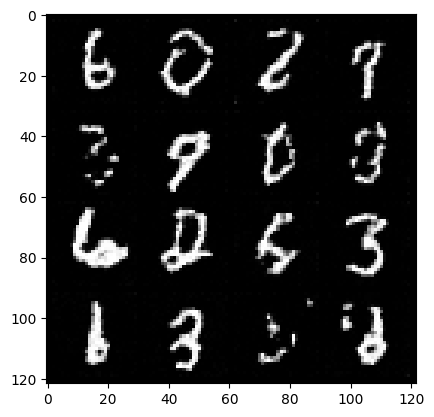

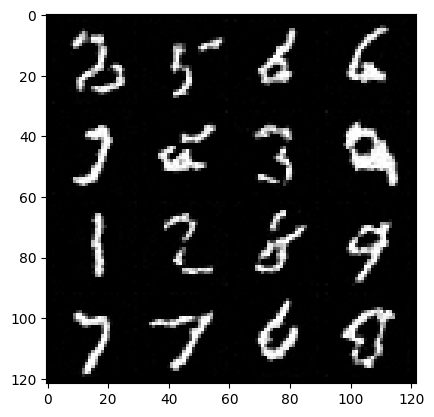

Validation: |          | 0/? [00:00<?, ?it/s]

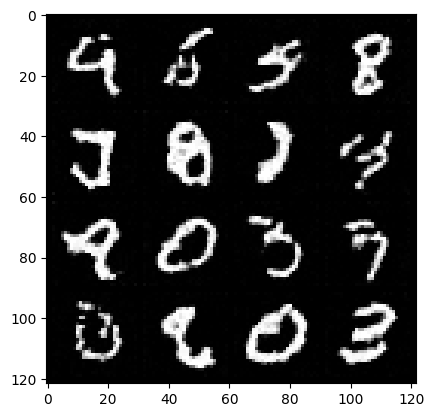

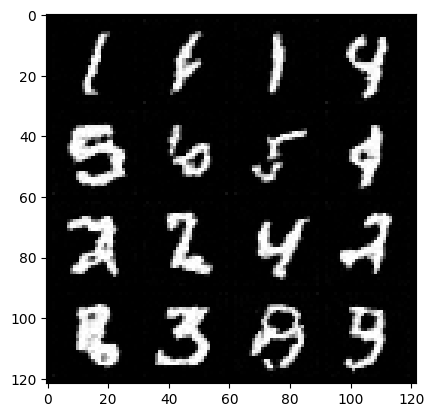

Validation: |          | 0/? [00:00<?, ?it/s]

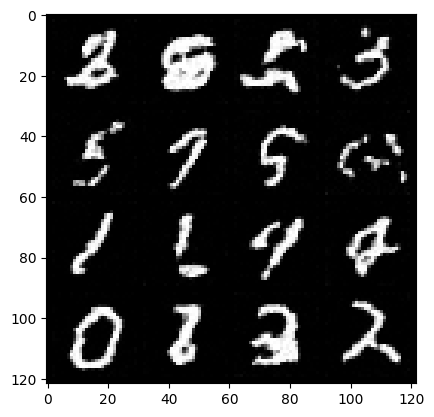

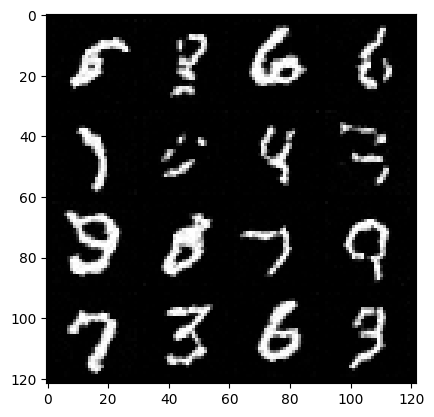

Validation: |          | 0/? [00:00<?, ?it/s]

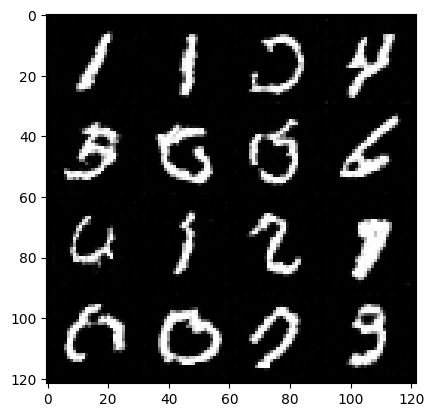

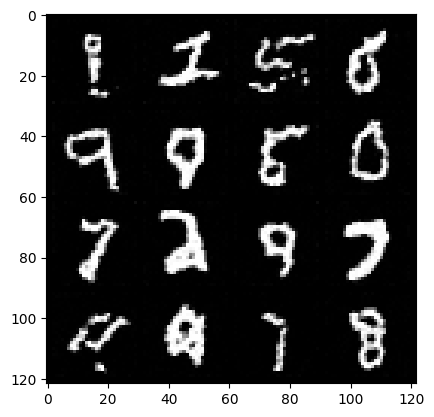

Validation: |          | 0/? [00:00<?, ?it/s]

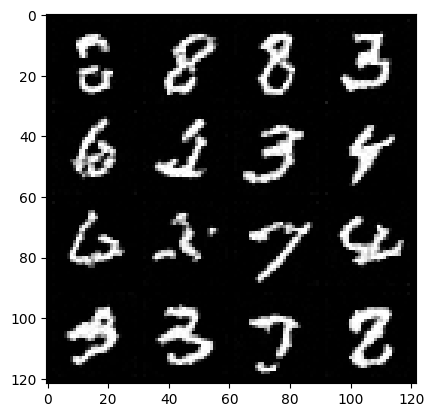

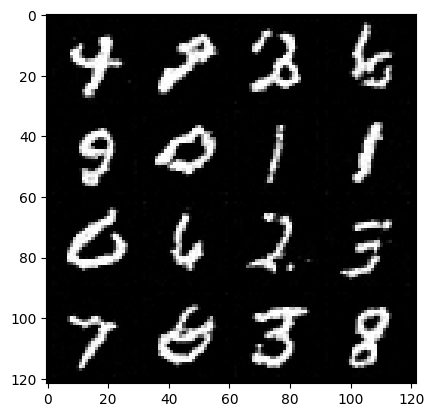

Validation: |          | 0/? [00:00<?, ?it/s]

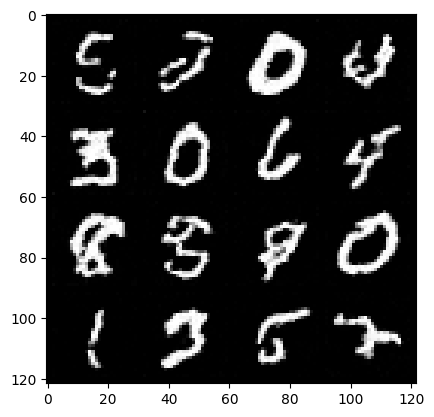

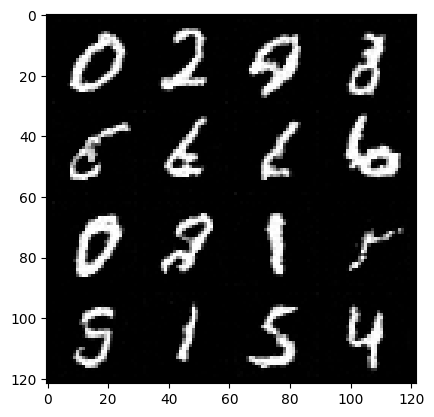

Validation: |          | 0/? [00:00<?, ?it/s]

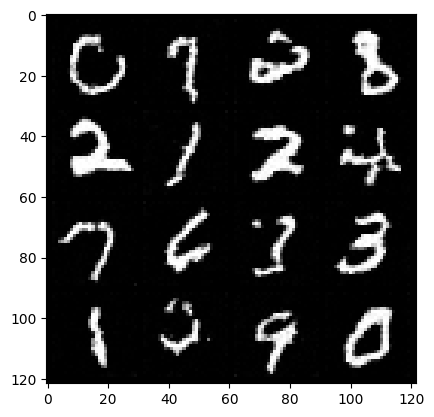

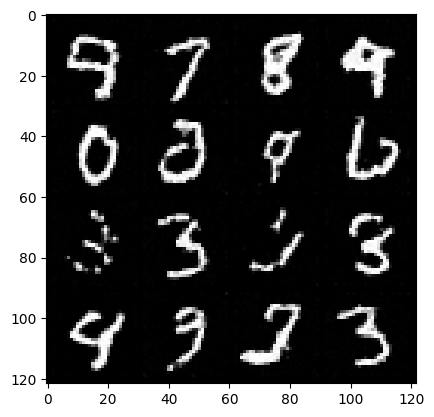

Validation: |          | 0/? [00:00<?, ?it/s]

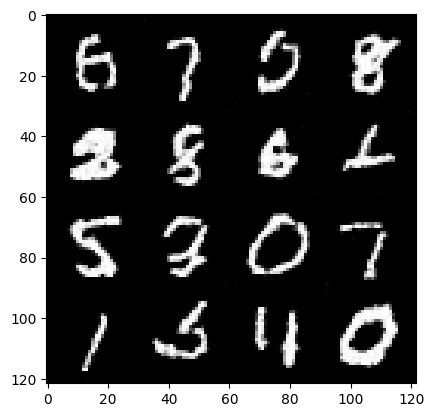

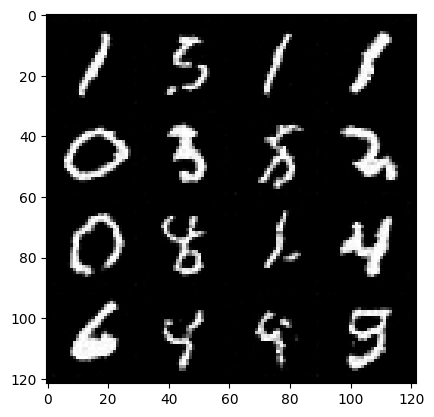

Validation: |          | 0/? [00:00<?, ?it/s]

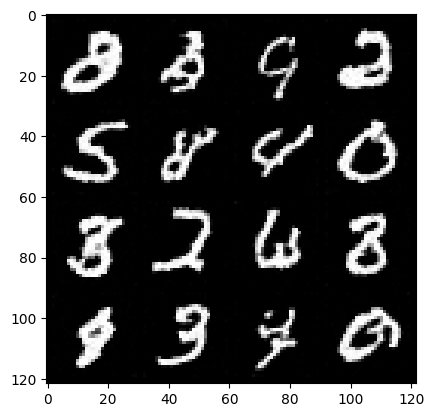

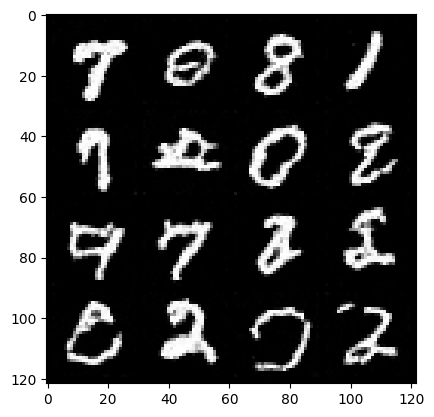

Validation: |          | 0/? [00:00<?, ?it/s]

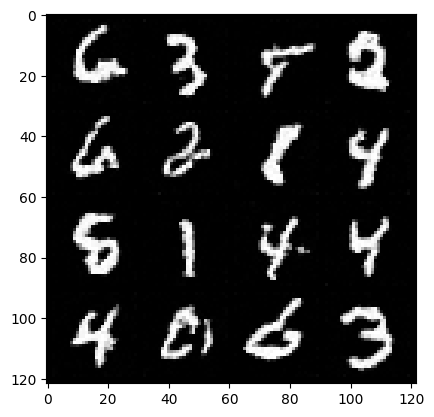

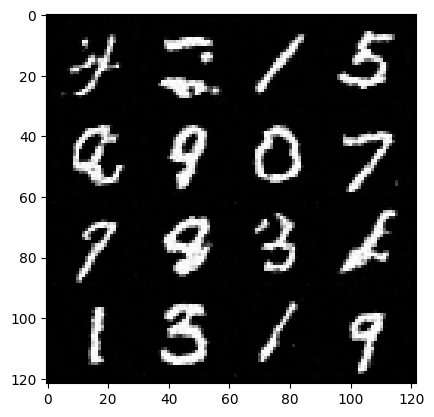

Validation: |          | 0/? [00:00<?, ?it/s]

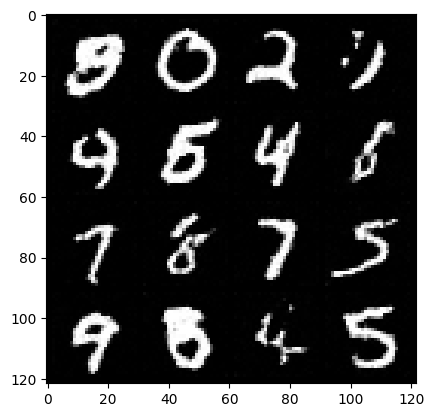

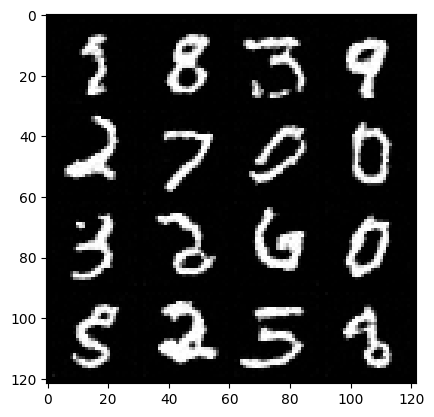

Validation: |          | 0/? [00:00<?, ?it/s]

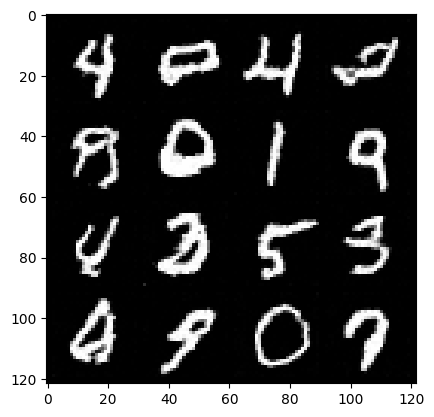

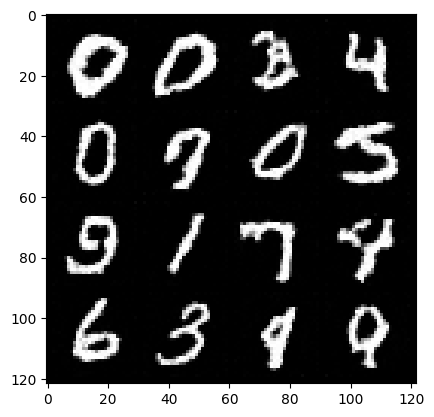

Validation: |          | 0/? [00:00<?, ?it/s]

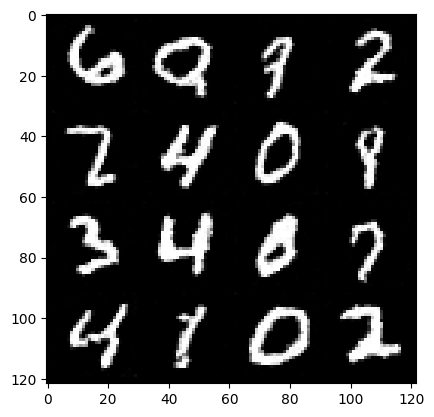

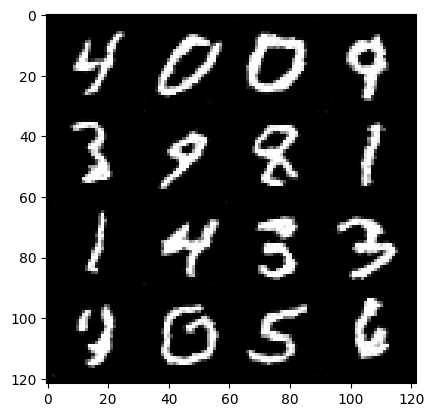

Validation: |          | 0/? [00:00<?, ?it/s]

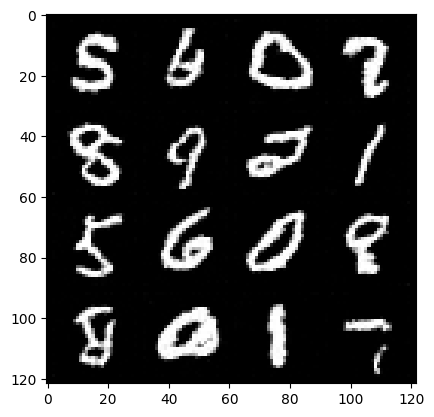

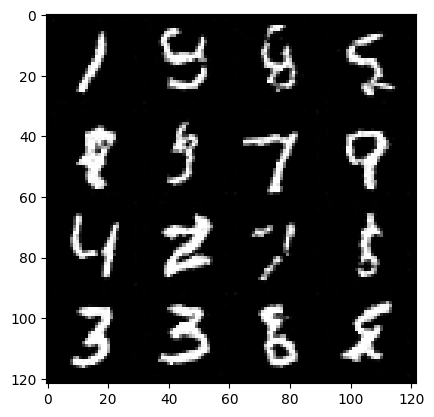

Validation: |          | 0/? [00:00<?, ?it/s]

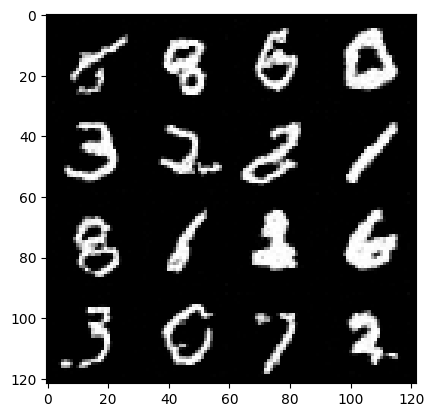

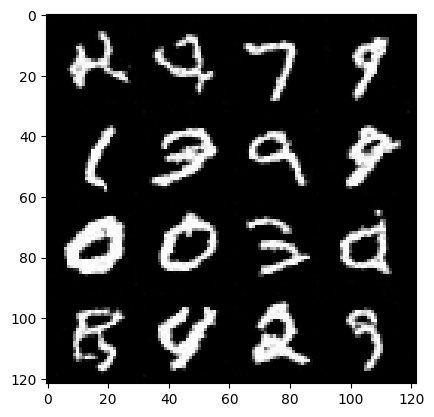

Validation: |          | 0/? [00:00<?, ?it/s]

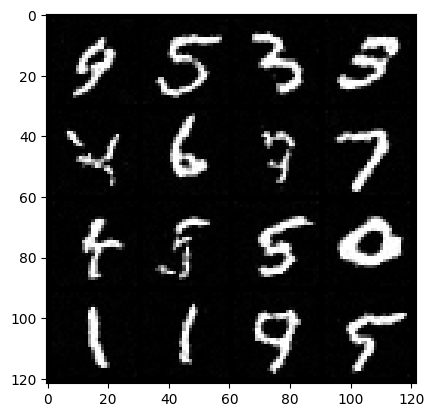

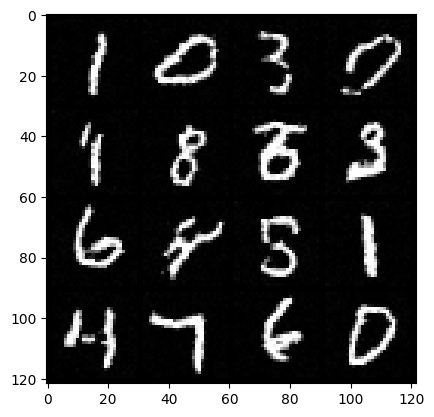

Validation: |          | 0/? [00:00<?, ?it/s]

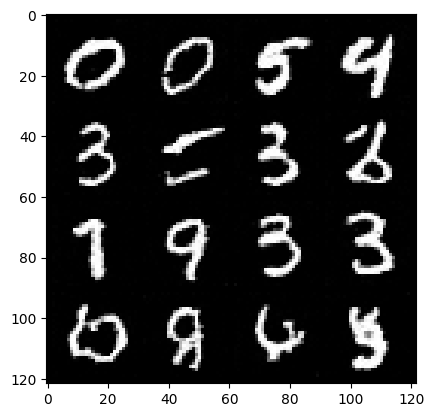

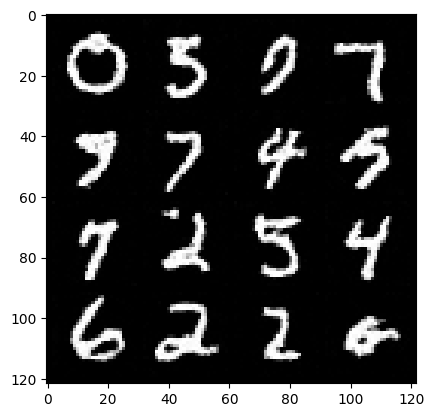

Validation: |          | 0/? [00:00<?, ?it/s]

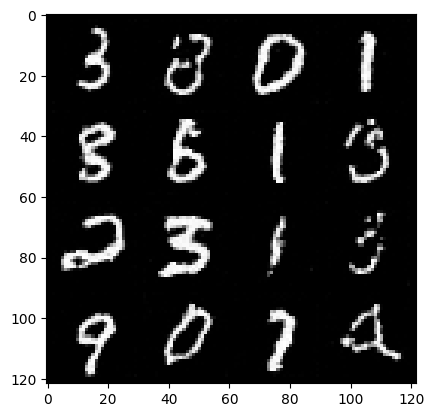

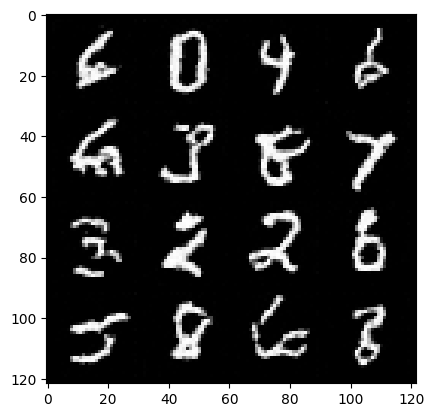

Validation: |          | 0/? [00:00<?, ?it/s]

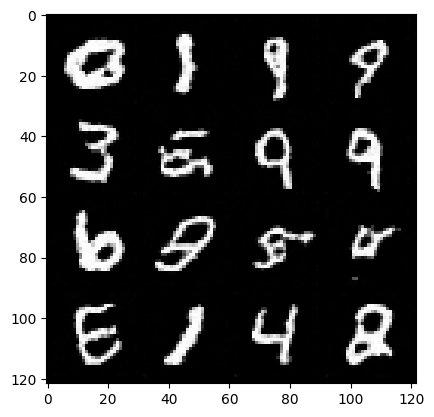

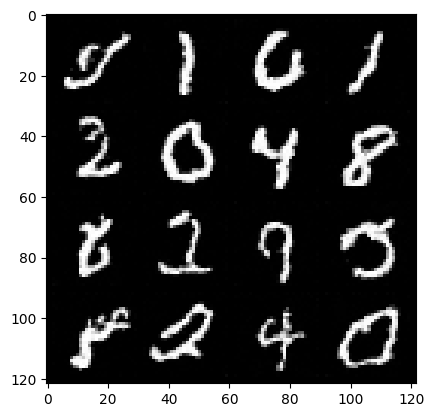

Validation: |          | 0/? [00:00<?, ?it/s]

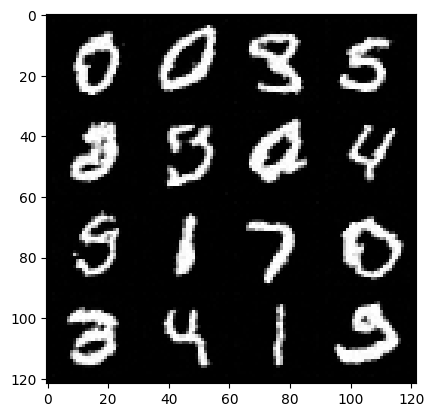

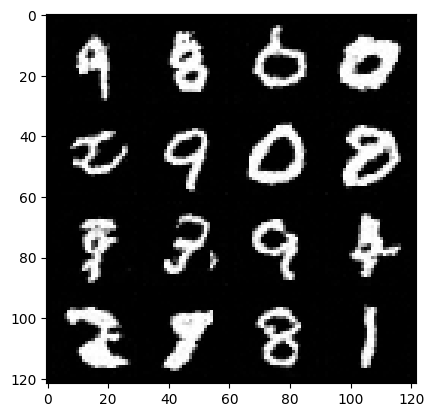

Validation: |          | 0/? [00:00<?, ?it/s]

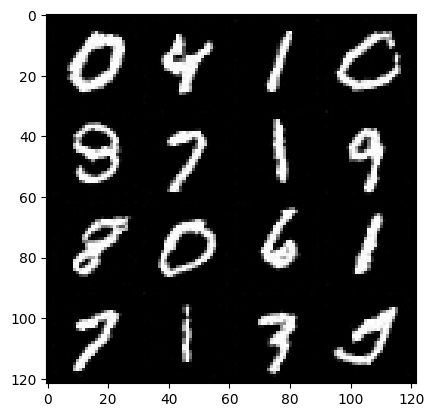

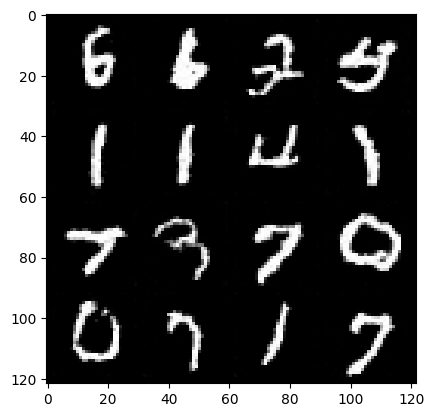

Validation: |          | 0/? [00:00<?, ?it/s]

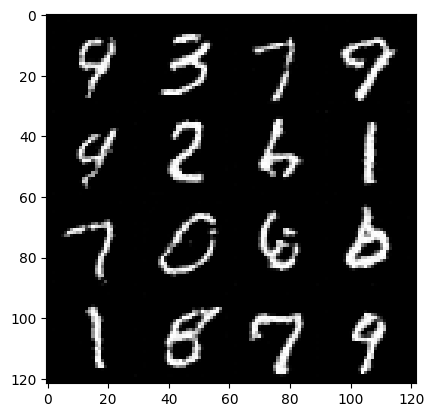

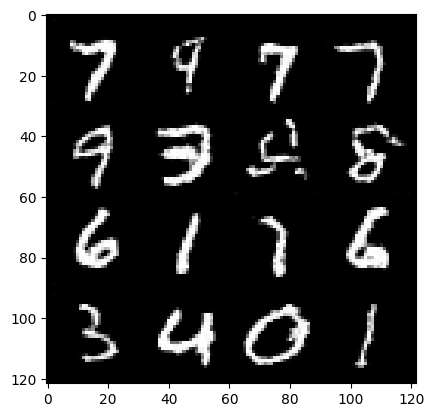

Validation: |          | 0/? [00:00<?, ?it/s]

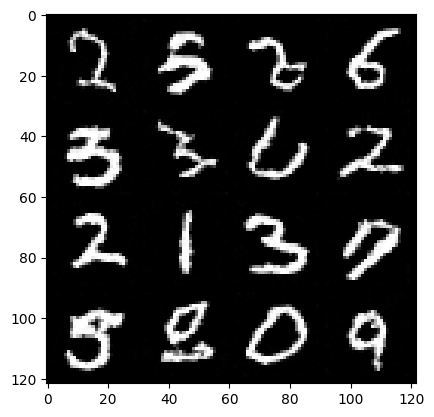

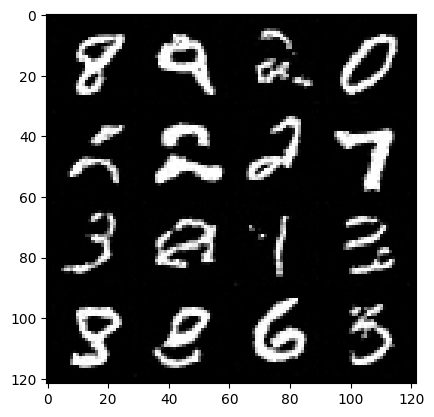

Validation: |          | 0/? [00:00<?, ?it/s]

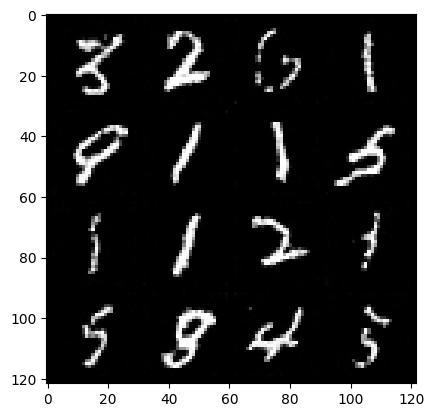

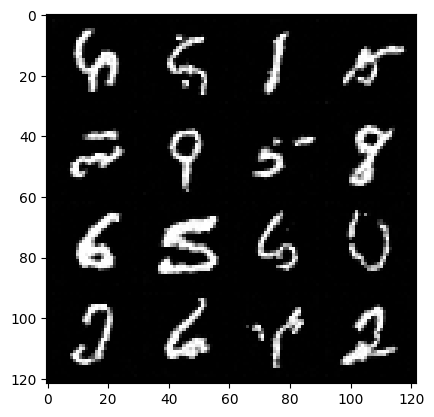

Validation: |          | 0/? [00:00<?, ?it/s]

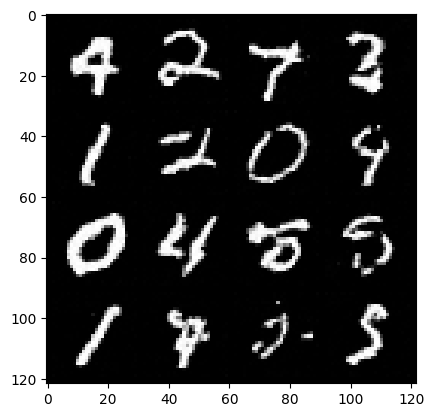

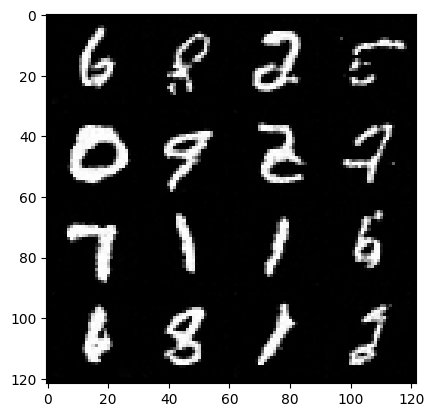

Validation: |          | 0/? [00:00<?, ?it/s]

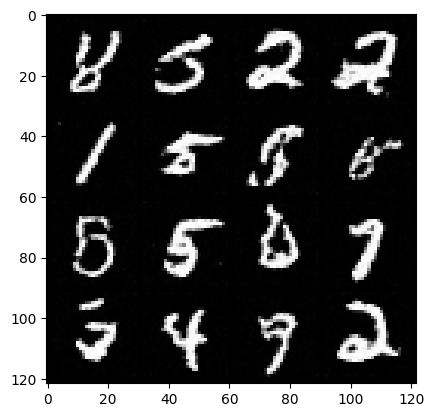

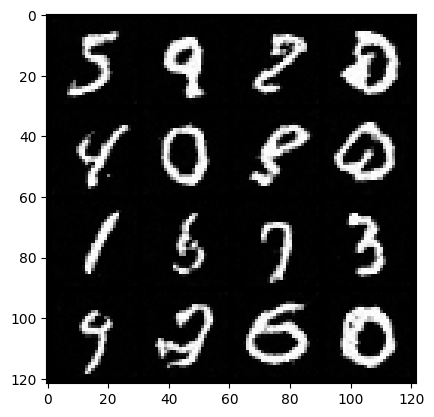

Validation: |          | 0/? [00:00<?, ?it/s]

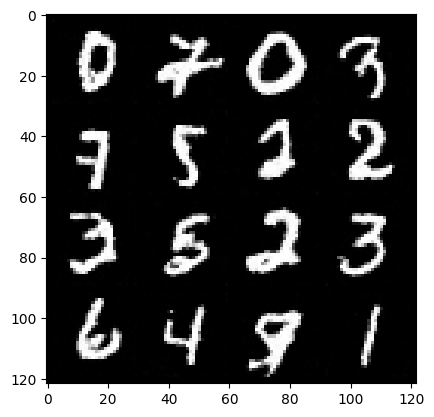

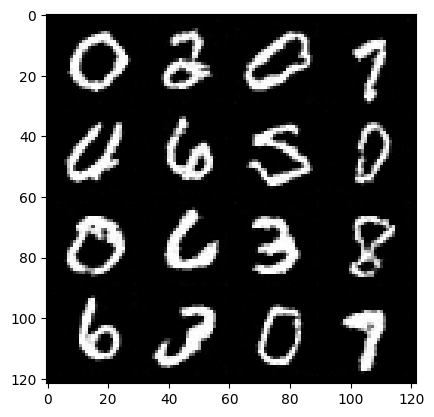

Validation: |          | 0/? [00:00<?, ?it/s]

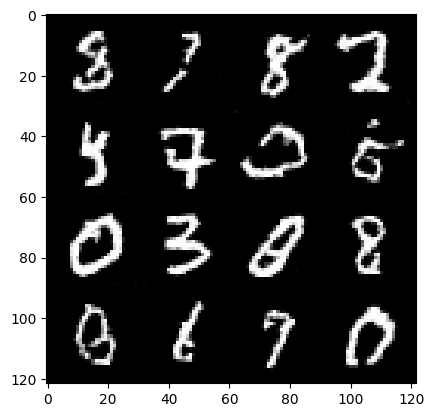

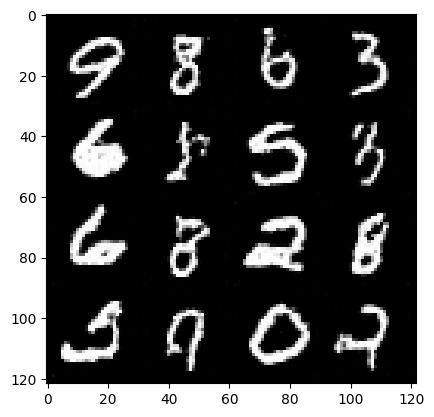

NameError: name 'exit' is not defined

In [118]:
trainer.fit(model, train_dloader, test_dloader)